In [ ]:
%load_ext autoreload
%autoreload 2

import parse_data.prepare_data as prepare_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import globals
import data_strings
import analysis.wall_visibility_and_choice as wall_visibility_and_choice
import trajectory_analysis.trajectory_headangle as trajectory_headangle
import data_extraction.get_indices as get_indices
import plotting.plot_probability_chose_wall as plot_probability_chose_wall
import analysis.conditioned_player_choice as conditioned_player_choice
from scipy.stats import wilcoxon

plt.rcParams['figure.dpi'] - 300

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


KeyError: 'fig.dpi'

### Rewriting of P(choice | visibility) analysis using the logic from opponent-visibility 

In [3]:
data_folder = data_strings.DATA_FOLDER
json_filenames_all_social = data_strings.JSON_FILENAMES_SOCIAL
json_filenames_all_solo = data_strings.JSON_FILENAMES_SOLO

In [6]:
json_filenames = json_filenames_all_social

In [7]:
df, trial_lists = prepare_data.prepare_data(data_folder, json_filenames, combine=False)

filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\first_experiments_2409\240913\2024-09-13_11-31-00_YansuJerrySocial.json
Data is from period before 2024-09-13 00:00:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.
Preprocessing complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\second_experiments_2409\240927\2024-09-27_14-25-20_SaraEmilySocial.json
Loading complete.
Preprocessing complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\third_experiments_2410\241017\2024-10-17_14-28-40_ShamirAbigailSocial.json
Loading complete.
Preprocessing complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\fourth_experiments_2410\241017\2024-10-17_16-41-38_ZimoElsaSocial.json
Loading complete.
Preprocessing complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\fifth_experiments_241112\2024-11-12_13-31-14_KhadijaWendySocial.json
Loading complete.
Preprocessing complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\sixth_experiments_241112\2024-11-12_15-23-24_Franc

In [8]:
df_solo, trial_lists_solo = prepare_data.prepare_data(data_folder, json_filenames_all_solo, combine=False)

filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\first_experiments_2409\240913\2024-09-13_11-23-37_YansuFirstSolo.json
Data is from period before 2024-09-13 00:00:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.
Preprocessing complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\first_experiments_2409\240913\2024-09-13_11-53-34_YansuSecondSolo.json
Data is from period before 2024-09-13 00:00:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.
Preprocessing complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\first_experiments_2409\240913\2024-09-13_11-23-50_JerryFirstSolo.json
Data is from period before 2024-09-13 00:00:00
Running dataframe through playerinfo_playerposition_conversion.
Loading complete.
Preprocessing complete.
filepath: D:\Users\Tom\OneDrive\PhD\SWC\data\first_experiments_2409\240913\2024-09-13_11-53-56_JerrySecondSolo.json
Data is from period before 2024-09-13 00:00:00
Running dataframe through player

Goal:
- Parameterise choice wall (if any), first_visible wall (if any), inferred choice

### Create filter funtions


#### These functions are left obsolete, because conditioned_player_choice stores the cleaned functions

In [67]:
def filter_trials_retrievable_choice(trial_list, player_id, inferred_choice):
    ''' Return the filtered trial list and list of indices from the original trial list that
        conform with player player_id having a recorded choice.
        This is required for accurate probabilities, because we do cannot include trials (as negative)
        where we do not know what the player's choice would have been. '''
    
    # get player choice (wall number) for each trial
    # inferred choice can be used here
    player_choice = wall_visibility_and_choice.get_player_wall_choice(trial_list, player_id,
                                                                        inferred_choice, debug=False)
    
    print(f"filter_trials_retrievable_choice - player_choice, inferred status {inferred_choice} is:\n{player_choice}")
    print(f"And the number of valid trials at this step is {np.sum(~np.isnan(player_choice))}")
    
    # filter trials list to only include trials where this player had a recorded choice
    player_recorded_choice_indices = np.where(~np.isnan(player_choice))

    # index the tuple and allow list-compatible indexing
    player_recorded_choice_indices = player_recorded_choice_indices[0].tolist()

    # Use a list comprehension to index the trial list with the indices list
    trial_list_filtered = [trial_list[i] for i in player_recorded_choice_indices]

    return trial_list_filtered, player_recorded_choice_indices

    

In [68]:
def filter_trials_one_wall_initially_visible(trial_list, player_id, wall_index, current_fov):
    ''' Return a filtered trial list and list of indices from the original trial list that
        conform to a single trial wall being visible to player player_id at trial start,
        conferred by wall_index (e.g. 0 or 1 for wall1 or wall2) '''
    
    # find wall visibility (at the trial start timepoint) for the full session
    (wall1_visible_session,
    wall2_visible_session) = wall_visibility_and_choice.get_walls_initial_visibility_session(trial_list,
                                                                    player_id, current_fov, debug=False)
    
    # use np bitwise operators to find trials with only the relevant wall visible
    if wall_index == 0:
        single_wall_visible_indices = np.where((wall1_visible_session == True) & (wall2_visible_session == False))
    elif wall_index == 1:
        single_wall_visible_indices = np.where((wall2_visible_session == True) & (wall1_visible_session == False))

    # index the tuple and allow list-compatible indexing
    single_wall_visible_indices = single_wall_visible_indices[0].tolist() 

    trial_list_filtered = [trial_list[i] for i in single_wall_visible_indices]

    return trial_list_filtered, single_wall_visible_indices


In [69]:
def filter_trials_both_walls_initially_visible(trial_list, player_id, current_fov):
    ''' Return a filtered trial list and list of indices from the original trial list that
        conform to both trial walls being visible to player player_id at trial start. '''
    
    # find wall visibility for the full session
    (wall1_visible_session,
    wall2_visible_session) = wall_visibility_and_choice.get_walls_initial_visibility_session(trial_list,
                                                                    player_id, current_fov,
                                                                    debug=False)
    
    # identify indices where both walls are visible initially
    both_walls_visible_indices = np.where((wall1_visible_session == True) & (wall2_visible_session == True))
    
    # index the tuple and allow list-compatible indexing
    both_walls_visible_indices = both_walls_visible_indices[0].tolist() 

    # Use a list comprehension to index the trial list with the indices list
    trial_list_filtered = [trial_list[i] for i in both_walls_visible_indices]

    return trial_list_filtered, both_walls_visible_indices

In [70]:
def filter_trials_one_wall_becomes_visible_first(trial_list, player_id,
                                                 current_fov, wall_index,
                                                 debug=False):
    ''' Return a filtered trial list and list of indices from the original trial list that
        conform to one of the trial walls becoming visible to player player_id during the trial
        before any other. '''
    
    # get whether given wall is visible first (and initially alone) for this player for a full session
    # TODO This can be checked again after having written
    given_wall_first_visible_session = wall_visibility_and_choice.get_given_wall_first_visible_session(trial_list,
                                                                                                       player_id,
                                                                                                       wall_index,
                                                                                                       current_fov,
                                                                                                       debug)
    
    print(f"filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:\n{given_wall_first_visible_session}")
    print(f"And the number of valid trials at this step is {np.sum(given_wall_first_visible_session == 1)}")


    
    # identify indices where wall wall_index becomes visible first
    given_wall_first_visible_indices = np.where(given_wall_first_visible_session == True)

    # index the tuple and allow list-compatible indexing
    given_wall_first_visible_indices = given_wall_first_visible_indices[0].tolist() 

    # Use a list comprehension to index the trial list with the indices list
    trial_list_filtered = [trial_list[i] for i in given_wall_first_visible_indices]


    return trial_list_filtered, given_wall_first_visible_indices

In [71]:
def filter_trials_player_chose_given_wall(trial_list, player_id, inferred_choice, given_wall_index):
    ''' Return a filtered trial list and list of indices from the original trial list 
        where player choice (winner + loser, or just winner) aligned with
        the given wall index (e.g., 0 for wall1) '''
    
    # get player choice (wall number) for each trial
    # inferred choice can be used here
    player_choice = wall_visibility_and_choice.get_player_wall_choice(trial_list, player_id,
                                                                        inferred_choice, debug=False)
    
    print(f"filter_trials_player_chose_given_wall - player choice array:\n{player_choice}")
    print(f"And the number trials identified with a choice at this step is {player_choice.size}")


    # get the truth array for whether the player choice wall aligns with the given wall parameter
    # to this function (NB. this is NOT the wall that was eventually chosen in the trial)
    given_wall_chosen_session = get_indices.was_given_wall_chosen(trial_list, player_choice,
                                                                  given_wall_index)
    
    print(f"given wall chosen array:\n{given_wall_chosen_session}")
    print(f"And the number trials identified with a choice at this step is {np.nonzero(given_wall_chosen_session)[0].size}")

    
    # find the indices of the trials in trial_list where the given wall was chosen by player player_id.
    # this will drop trials where the given wall was not chosen, and trials without retrievable choice information
    given_wall_chosen_indices = np.where(given_wall_chosen_session == True)
    print(f"given wall chosen true indices:\n{given_wall_chosen_indices}")
    
    # index the tuple and allow list-compatible indexing
    given_wall_chosen_indices = given_wall_chosen_indices[0].tolist()

    # use a list comprehension to index the trial list with the indices list
    trial_list_filtered = [trial_list[i] for i in given_wall_chosen_indices]

    # return filtered trial_list, and list of indices with which to index the original list
    return trial_list_filtered, given_wall_chosen_indices
    


In [72]:
def filter_trials_player_won(trial_list, player_id):
    ''' Return a filtered trial list and list of indices from the original trial list 
        where player player_id won. '''
    
    # get trigger activators for this session
    trigger_activators = get_indices.get_trigger_activators(trial_list)
    
    # find the indices of the trials in trial_list where player player_id won
    this_player_wins_indices = np.where(trigger_activators == player_id)
    
    # index the tuple and allow list-compatible indexing
    this_player_wins_indices = this_player_wins_indices[0].tolist()

    # use a list comprehension to index the trial list with the indices list
    trial_list_filtered = [trial_list[i] for i in this_player_wins_indices]

    # return filtered trial_list, and list of indices with which to index the original list
    return trial_list_filtered, this_player_wins_indices
    


In [46]:
## calculate probability

In [73]:
def calculate_probability_choose_wall(trial_list, trial_list_choice_filtered):
    ''' Given a trial list (pre-filtered, but not for choice), calculate the probability that 
        a player will choose a given wall value as the proportion of trials from the trial
        list in which the player chose the wall value.
        More complex use of this function could involve e.g. filtering the trial list for 
        trials where Low was first seen and the Opponent is visible, and then further filtering
        for player choice being 'Low', to find probability of (choose Low | first visible) under the
        condition of Other visibility at trial start. '''
        
    
    # use the length of the trial list pre-choice filtering, and the length of the trial list post-choice
    # filtering (e.g. with filter_trials_player_chose_given_wall) to calculate the proportion of 
    # relevant trials that a player chose a specific wall
    try:
        probability_chose_wall = len(trial_list_choice_filtered)/len(trial_list)
    except ZeroDivisionError:
        probability_chose_wall = np.nan

    return probability_chose_wall
    
    

In [48]:
## Umbrella functions of filters followed by probability calculation

In [65]:
def probability_trial_outcome_given_conditions(trial_list, player_id,
                                               visible_wall_index, chosen_wall_index,
                                               inferred_choice, current_fov,
                                               return_trial_indices=False, debug=False):
    ''' Take a trial list and filter based on existence of player_id player choice,
        and whether a specific wall becomes visible alone first (if visible_wall_index is not None). 
        Then, filter this trial list by the player choice being for a specific trial wall 
        (if chosen_wall_index is not None) and take the proportion of trials remaining
        as the probability of making this choice conditioned on our chosen filters.
        Returns probability of choosing a trial wall. 
        inferred_choice decides whether to include inferred choice for identifying retrievable choice and chosen wall.
        visible_wall_index and chosen_wall_index control wall initial visibility and player choice filters respectively. '''
    
    if debug:
      print(f"Next session, player_id {player_id}")

    # filter trials with a retrievable choice for this player (trials only valid for analysis if we 
    # have a recorded choice for the player)
    (trial_list_filtered,
    filtered_indices) = filter_trials_retrievable_choice(trial_list, player_id, inferred_choice)

    if debug:
      print(f"Len 'player choice exists' indices: {len(filtered_indices)}")


    # filter based on single wall visibility if requested
    if visible_wall_index is not None: 
        # filter with visible_wall_index seen first, alone in a trial
        (trial_list_filtered,
        filtered_indices) = filter_trials_one_wall_becomes_visible_first(trial_list_filtered, player_id,
                                                                     current_fov, wall_index=visible_wall_index)
    if debug:
      print(f"Len '{visible_wall_index} seen first, alone': {len(filtered_indices)}")


    # filter based on chosen wall if requested
    if chosen_wall_index is not None:
        # filter with chosen_wall_index chosen
        (trial_list_filtered_choice,
        filtered_indices_choice) = filter_trials_player_chose_given_wall(trial_list_filtered, player_id,
                                                                  inferred_choice,
                                                                  given_wall_index=chosen_wall_index)
    else: # otherwise, default to all wins for this player
        (trial_list_filtered_choice,
        filtered_indices_choice) = filter_trials_player_won(trial_list_filtered, player_id)
       
    if debug:
      print(f"Len '{chosen_wall_index} index wall chosen by player {player_id}': {len(filtered_indices_choice)}")

    
    # find the probability of the player choosing the given wall index, considering only trials that are filtered
    # prior to choice filtering
    probability_chose_wall = calculate_probability_choose_wall(trial_list_filtered, trial_list_filtered_choice)

    if debug:
      print(f"Probability player chose wall given these conditions: {probability_chose_wall}")

    if not return_trial_indices:
      return probability_chose_wall
    else:
      return probability_chose_wall, filtered_indices, filtered_indices_choice

In [50]:
## Session umbrella functions for collecting probabilities data for all players in all sessions

In [64]:
def probability_trial_outcome_given_conditions_all_sessions(session_trial_lists, inferred_choice,
                                                            current_fov,
                                                            chosen_wall_index, visible_wall_index,
                                                            trial_type=globals.HIGH_LOW,
                                                            return_trial_indices=False, debug=False):
    ''' Return the probability array across all players and sessions 
        that a trial has a particular outcome given conditions.
        Conditions here are only wall visible_wall_index visible alone, first.
        Outcome is that wall chosen_wall_index is chosen, or just that player player_id
        won if this parameter is None'''

    probabilities = np.full(len(session_trial_lists)*2, np.nan)
    filtered_trial_indices_list = []
    filtered_trial_indices_choice_list = []
    trial_list_index = 0

    # loop through the number of players, filling 2 slots per session analysed
    for i in range(0,len(session_trial_lists)*2, 2):

        trial_list = session_trial_lists[trial_list_index]

        # filter trial list for HighLow trialtype
        trial_indices = get_indices.get_trials_trialtype(trial_list, trial_type=trial_type)
        trial_list_filtered = [trial_list[i] for i in trial_indices]

        for player_id in [0,1]:
            # return the lists of trial indices alongside the trial outcome probability if specified
            # (both for the condition filtered trials and the condition-plus-choice filtered trials)
            if not return_trial_indices:
                probabilities[i + player_id] = probability_trial_outcome_given_conditions(trial_list_filtered, player_id,
                                                                                        visible_wall_index, chosen_wall_index,
                                                                                        inferred_choice, current_fov,
                                                                                        debug=debug)
            else:
                (probabilities[i + player_id],
                 filtered_trial_indices,
                 filtered_trial_indices_choice) = probability_trial_outcome_given_conditions(trial_list_filtered, player_id,
                                                                                        visible_wall_index, chosen_wall_index,
                                                                                        inferred_choice, current_fov,
                                                                                        return_trial_indices=return_trial_indices, debug=debug)
                
            filtered_trial_indices_list.append(filtered_trial_indices)
            filtered_trial_indices_choice_list.append(filtered_trial_indices_choice)

        trial_list_index += 1
        
        

    return probabilities, filtered_trial_indices_list, filtered_trial_indices_choice_list


In [52]:
## Plotting functions for boxplot line graphs

In [53]:
# plot_probability_chose_wall.boxplot_probability_choose_wall(wall_choice_probabilities, wall_choice_labels, ylabel="P(Choose first wall seen)")

### Sandbox

### Newer code, using analysis/conditioned_player_choice.py

In [49]:
# variables
inferred_choice = True
current_fov = 110
chosen_wall_index = 0
visible_wall_index = 0
wall_initial_vis_only = False
other_visible = None
inverse_other_visible = False
wall_sep = 1
solo = False
data_size_cutoff = 6

In [50]:
# len(numerator1[0][0])

In [51]:
## All social datasets
(probabilities1,
 numerator1,
  denominator1) = conditioned_player_choice.probability_trial_outcome_given_conditions_all_sessions(trial_lists, inferred_choice, current_fov,
                                                            chosen_wall_index=chosen_wall_index, visible_wall_index=visible_wall_index,
                                                            other_visible=other_visible, wall_initial_vis_only=wall_initial_vis_only,
                                                            wall_sep=wall_sep, inverse_other_visible=inverse_other_visible, solo=solo,
                                                            trial_type=globals.HIGH_LOW, data_size_cutoff=data_size_cutoff, debug=False)

filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0.
 0. 1. 1. 1.]
And the number of valid trials at this step is 12
filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 1.]
And the number of valid trials at this step is 11


d:\tom\documents\swc\repos\octagon_analysis\trajectory_analysis\trajectory_vectors.py:321: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity_this_wall = dot_product[wall_num]/(player_to_alcove_vector_norms[wall_num] * player_vector_norm)
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:47: RuntimeWarning: Mean of empty slice
  return np.argmax(np.nanmean(cosine_similarity_trajectory, axis=1))
d:\tom\documents\swc\repos\octagon_analysis\analysis\loser_inferred_choice.py:149: RuntimeWarning: Mean of empty slice
  highest_alignment_val = np.max(np.nanmean(cosine_similarity_trajectory, axis=1))


filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
And the number of valid trials at this step is 2
fewer than 6 trials in the denominator, returning np.nan instead of probability
filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]
And the number of valid trials at this step is 11
filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
And the number of valid trials at this step is 10
filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0.
 1. 0. 0. 1. 1. 0. 0. 0. 0.]
And the number of valid tria

In [52]:
# variables
inferred_choice = True
current_fov = 110
chosen_wall_index = 0
visible_wall_index = 1
wall_initial_vis_only = False
other_visible = None
inverse_other_visible = False
wall_sep = 1
solo = False
data_size_cutoff = 6

In [53]:
# np.mean([len(arr) for arr in denominator2[0]])

In [54]:
## All social datasets
(probabilities2,
 numerator2,
  denominator2) = conditioned_player_choice.probability_trial_outcome_given_conditions_all_sessions(trial_lists, inferred_choice, current_fov,
                                                            chosen_wall_index=chosen_wall_index, visible_wall_index=visible_wall_index,
                                                            other_visible=other_visible, wall_initial_vis_only=wall_initial_vis_only,
                                                            wall_sep=wall_sep, inverse_other_visible=inverse_other_visible, solo=solo,
                                                            trial_type=globals.HIGH_LOW, data_size_cutoff=data_size_cutoff, debug=True)

Next session, player_id 0
initial original indices are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
Len 'player choice exists' indices: 28
filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1.
 1. 0. 0. 0.]
And the number of valid trials at this step is 9
Len '1 with initial_vis_only False': 9
Probability player chose wall given these conditions: 0.3333333333333333
Final original indices are: [ 5  6  9 15 16 17 21 26 27]
Next session, player_id 1
initial original indices are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34]
Len 'player choice exists' indices: 32
filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 0.]
And the number o

In [391]:
probabilities1, probabilities2

(array([[0.83333333, 0.81818182],
        [       nan, 1.        ],
        [0.7       , 0.75      ],
        [0.76923077, 0.95      ],
        [       nan, 1.        ],
        [0.94444444, 0.8       ],
        [0.90909091, 0.92307692],
        [0.77777778, 0.5       ],
        [0.72727273, 0.83333333],
        [0.88235294, 0.44444444],
        [0.83333333, 0.95      ],
        [0.77777778, 0.92857143],
        [1.        , 0.78571429],
        [1.        , 1.        ],
        [0.84615385, 0.7       ],
        [0.90909091, 0.85714286],
        [0.90909091, 0.7       ],
        [1.        , 0.95238095],
        [0.6       , 0.63157895]]),
 array([[0.33333333, 0.14285714],
        [0.        , 0.75      ],
        [0.44444444, 0.22222222],
        [0.45454545, 0.66666667],
        [       nan, 0.625     ],
        [0.8       , 0.18181818],
        [0.375     , 0.66666667],
        [0.4375    , 0.5625    ],
        [0.57142857, 0.2       ],
        [0.65      ,        nan],
        [0. 

In [43]:
def combine_multiple_conditions(indices_condition1, indices_condition2):
    ''' Combine the trial indices from multiple conditions.
        Takes 2 lists, each with nested lists for player 0 and 1,
        which contains the arrays of trial indices for each session.
        Returns 1 list containing the combined trial indices from both conditions,
        with player 1 concatenated to player 0. '''
    
    if len(indices_condition1) == 2: # if not solo
        # flatten the list across player 0 and player 1 (s.t. same-session players are consecutive)
        indices_condition1_flattened = [player for session in zip(indices_condition1[0], indices_condition1[1]) for player in session]
        indices_condition2_flattened = [player for session in zip(indices_condition2[0], indices_condition2[1]) for player in session]

    else:
        print("not of length 2, inferring solo")
        indices_condition1_flattened = indices_condition1
        indices_condition2_flattened = indices_condition2
    
    # concatenate condition arrays across trial index
    condition_concatenated_indices = [np.sort(np.concatenate([a,b])) for a,b in zip(indices_condition1_flattened, indices_condition2_flattened)]
                
    return condition_concatenated_indices

In [44]:
# get the indices for the combined condition1 and condition2
# both the choice filtered and the pre-choice filtered indices, so we can calculate probabilities for each player
filtered_trial_choice_indices_total = combine_multiple_conditions(numerator1, numerator2)
filtered_trial_indices_total = combine_multiple_conditions(denominator1, denominator2)

In [45]:
# probability of specified choice for each player given condition
data_size_cutoff = data_size_cutoff
probabilities3 = np.full(len(filtered_trial_indices_total), np.nan)

# only include this probability if the summed denominators for the trial are of length > data_size_cutoff
for i in range(len(filtered_trial_indices_total)):
    if len(filtered_trial_indices_total[i]) <= data_size_cutoff:
        print(f"fewer than {data_size_cutoff} trials in the denominator, returning np.nan instead of probability")
        probabilities3[i] = np.nan
    else:
        probabilities3[i] = conditioned_player_choice.calculate_probability_choose_wall(filtered_trial_indices_total[i], filtered_trial_choice_indices_total[i])

In [46]:
# non-combined probabilities need row-major order unravelling, as they are shaped num_sessions,num_players
wall_choice_probabilities = [probabilities3, probabilities2.ravel(), probabilities1.ravel()]

d:\tom\documents\swc\repos\octagon_analysis\plotting\plot_probability_chose_wall.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  for i in range(dataset_size):


<Axes: ylabel='P(Choose first visible)'>

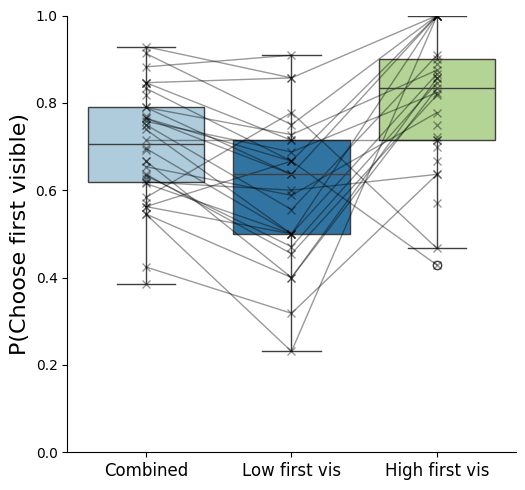

In [365]:
# plot social combined, low-first-vis and high-first-vis conditions for probability of choosing the first visible wall
plot_probability_chose_wall.boxplot_probability_choose_wall(wall_choice_probabilities, ['Combined', 'Low first vis', 'High first vis'], ylabel="P(Choose first visible)", fontsize=16)

d:\tom\documents\swc\repos\octagon_analysis\plotting\plot_probability_chose_wall.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Condition", y="Probability", data=df, palette=custom_palette, width=.8)
d:\tom\documents\swc\repos\octagon_analysis\plotting\plot_probability_chose_wall.py:60: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(x="Condition", y="Probability", data=df, palette=custom_palette, width=.8)


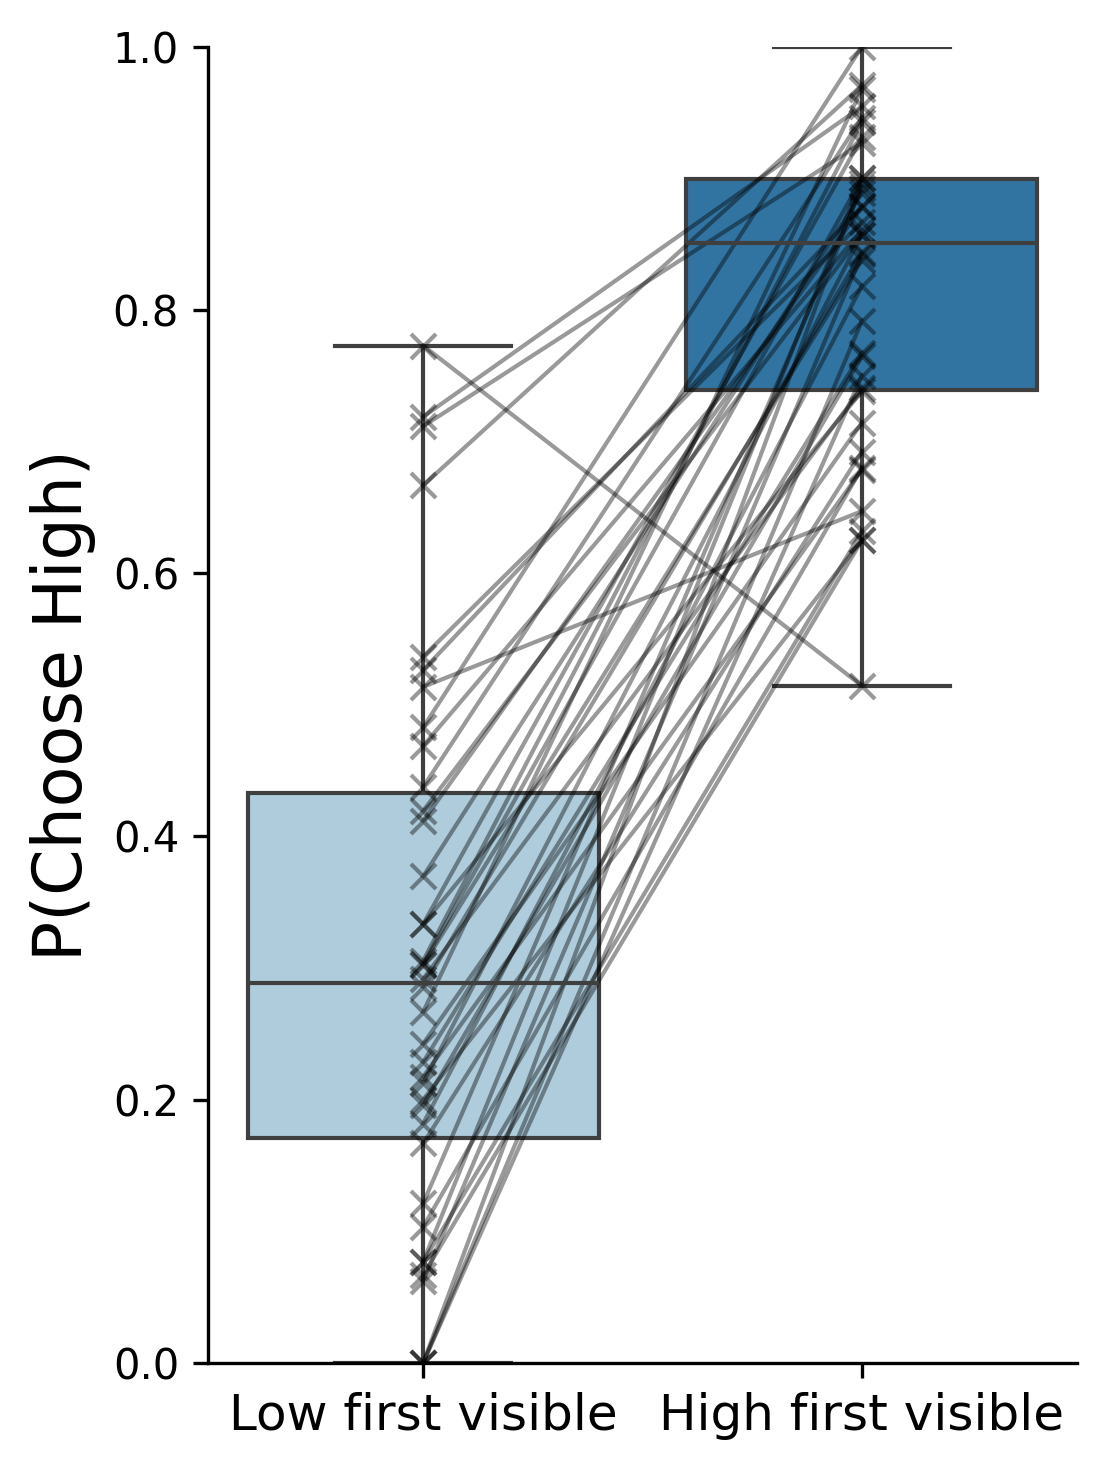

In [18]:
# repeat the above plot, but restricted to only low-first-vis and high-first-vis conditions
wall_choice_probabilities = [probabilities2.ravel(), probabilities1.ravel()]
plot_probability_chose_wall.boxplot_probability_choose_wall(wall_choice_probabilities, ['Low first visible', 'High first visible'], ylabel="P(Choose High)",
                                                            fontsize=16)

plt.rcParams['figure.dpi'] = 300

In [267]:
denominator2

[[array([ 9, 11, 14, 16, 18, 21, 29, 30, 31, 33, 34, 37, 39]),
  array([ 0,  2,  3,  4,  5,  7, 17, 18, 20, 21]),
  array([ 1,  4,  7,  8, 11, 13, 16, 22, 23]),
  array([ 3,  4,  7,  8, 10, 11, 14, 17, 19, 21, 24, 26, 27, 29, 32, 33, 36,
         38, 45]),
  array([ 3,  4,  7, 11, 16]),
  array([ 2,  5,  6,  7,  8,  9, 13, 14, 18, 20]),
  array([ 4,  5,  6,  7,  9, 10, 12, 14, 16, 18, 19, 20, 23, 25, 27, 28, 30]),
  array([ 7,  8,  9, 13, 14, 16, 19, 23]),
  array([ 0,  1,  9, 10, 12, 16, 20]),
  array([1, 3, 4, 7]),
  array([ 0,  3,  4,  6,  8,  9, 10, 11, 13, 14, 18, 20, 21, 22, 23, 24, 25,
         26, 28]),
  array([ 4,  5,  7, 19, 22, 24, 27, 30]),
  array([ 0,  3,  4,  7,  8,  9, 10, 11, 13, 16, 20]),
  array([ 0,  1,  3,  4, 10, 11, 12, 16, 17, 20, 24, 25, 26, 30]),
  array([ 1,  2,  4,  6,  7, 11, 16, 17, 21]),
  array([ 0,  1,  2,  4,  5,  8, 10, 11, 13, 14, 15, 16, 18, 19]),
  array([ 1,  5, 11, 12, 13, 14, 22]),
  array([ 0,  3,  4,  6,  7, 13, 14, 15, 16]),
  array([ 0,  4,

In [269]:
np.nanmean([len(list) for list in denominator2[0] + denominator2[1]])

np.float64(10.894736842105264)

In [270]:
trials_in_condition =np.array([len(list) for list in denominator2[0] + denominator2[1]])

In [271]:
trials_in_condition

array([13, 10,  9, 19,  5, 10, 17,  8,  7,  4, 19,  8, 11, 14,  9, 14,  7,
        9,  7, 18, 11, 13, 18,  4, 11, 11, 15,  9,  2, 14, 17, 16, 13, 13,
       11,  5,  6,  7])

In [272]:
np.count_nonzero(trials_in_condition > 5)

33

### Wilcoxon signed rank test
- This is a little violated because of lack of independence between individuals with exactly one other individual
- Address with LMMs in future?

In [293]:
probabilities1.ravel()

array([0.81818182, 0.76744186, 0.75      , 0.85714286, 0.74074074,
       0.89285714, 0.85714286, 0.88888889, 0.9       , 0.93103448,
       0.94594595, 0.68      , 0.96774194, 0.86046512, 0.84375   ,
       0.73809524, 0.67857143, 0.69230769, 0.87878788, 0.63157895,
       0.79166667, 0.92682927, 0.625     , 0.86666667, 1.        ,
       0.71428571, 0.97058824, 0.89655172, 0.84210526, 0.76470588,
       0.87804878, 0.83783784, 0.94285714, 0.64705882, 0.9       ,
       0.95454545, 0.625     , 0.51428571])

In [294]:
wilcoxon_nan_mask = ~np.isnan(probabilities1.ravel()) & ~np.isnan(probabilities2.ravel())
probabilities1_wilcoxon = probabilities1.ravel()[wilcoxon_nan_mask]
probabilities2_wilcoxon = probabilities2.ravel()[wilcoxon_nan_mask]

In [295]:
# Perform Wilcoxon signed-rank test
stat, p_value = wilcoxon(probabilities1_wilcoxon.ravel(), probabilities2_wilcoxon.ravel())

# Print results
print(f"Wilcoxon test statistic: {stat}")
print(f"P-value: {p_value}")

Wilcoxon test statistic: 4.0
P-value: 5.093170329928398e-11


### Repeating the above code for solo sessions

In [20]:
## Combine every two consecutive trial lists, to append post-social solo session to pre-social solo session
trial_lists_solo_combined_sessions = []
cut_trials = 6
for i in range(0, len(trial_lists_solo), 2):
    trial_lists_solo_combined_sessions.append(trial_lists_solo[i][cut_trials:] + trial_lists_solo[i+1])



In [21]:
len(trial_lists_solo_combined_sessions[0][5:])

55

In [24]:
# variables
inferred_choice = True
current_fov = 110
chosen_wall_index = 0
visible_wall_index = 0
wall_initial_vis_only = False
other_visible = None
inverse_other_visible = False
wall_sep = None
solo = True
data_size_cutoff = 6

if solo == True:
    inferred_choice = False

In [25]:
## Feeding in solo trial lists for solo analysis
(probabilities1_solo,
 numerator1_solo,
  denominator1_solo) = conditioned_player_choice.probability_trial_outcome_given_conditions_all_sessions(trial_lists_solo_combined_sessions, inferred_choice, current_fov,
                                                            chosen_wall_index=chosen_wall_index, visible_wall_index=visible_wall_index,
                                                            other_visible=other_visible, wall_initial_vis_only=wall_initial_vis_only,
                                                            wall_sep=wall_sep, inverse_other_visible=inverse_other_visible, solo=solo,
                                                            trial_type=globals.HIGH_LOW, data_size_cutoff=data_size_cutoff, debug=True)

Next session, player_id 0
initial original indices are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]
Len 'player choice exists' indices: 51
filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0.
 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 0. 0. 1.]
And the number of valid trials at this step is 16
Len '0 with initial_vis_only False': 16
Probability player chose wall given these conditions: 1.0
Final original indices are: [ 1 18 19 22 24 27 29 34 35 37 38 40 42 44 46 50]
Next session, player_id 0
initial original indices are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Len 'player choice exists' indices: 50
filter_trials_one_wall_become

In [127]:
probabilities1_solo.shape

(38,)

In [26]:
# variables
inferred_choice = True
current_fov = 110
chosen_wall_index = 1
visible_wall_index = 1
wall_initial_vis_only = False
other_visible = None
inverse_other_visible = False
wall_sep = None
solo = True
data_size_cutoff = 6

if solo == True:
    inferred_choice = False

In [27]:
## Feeding in solo trial lists for solo analysis

(probabilities2_solo,
 numerator2_solo,
  denominator2_solo) = conditioned_player_choice.probability_trial_outcome_given_conditions_all_sessions(trial_lists_solo_combined_sessions, inferred_choice, current_fov,
                                                            chosen_wall_index=chosen_wall_index, visible_wall_index=visible_wall_index,
                                                            other_visible=other_visible, wall_initial_vis_only=wall_initial_vis_only,
                                                            wall_sep=wall_sep, inverse_other_visible=inverse_other_visible, solo=solo,
                                                            trial_type=globals.HIGH_LOW, data_size_cutoff=data_size_cutoff, debug=True)

Next session, player_id 0
initial original indices are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]
Len 'player choice exists' indices: 51
filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1.
 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1.
 1. 1. 0.]
And the number of valid trials at this step is 21
Len '1 with initial_vis_only False': 21
Probability player chose wall given these conditions: 0.7619047619047619
Final original indices are: [ 0  3 14 16 17 20 21 23 25 26 28 30 31 32 33 39 43 45 47 48 49]
Next session, player_id 0
initial original indices are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Len 'player choice exists' indices: 50

In [32]:
probabilities1_solo[19], probabilities2_solo[19]

(np.float64(1.0), np.float64(1.0))

In [33]:
# get the indices for the combined condition1 and condition2
# both the choice filtered and the pre-choice filtered indices, so we can calculate probabilities for each player
filtered_trial_choice_indices_total_solo = combine_multiple_conditions(numerator1_solo, numerator2_solo)
filtered_trial_indices_total_solo = combine_multiple_conditions(denominator1_solo, denominator2_solo)

not of length 2, inferring solo
not of length 2, inferring solo


In [34]:
len(denominator1_solo), len(denominator2_solo), len(filtered_trial_indices_total_solo)

(38, 38, 38)

In [35]:
# probability of specified choice for each player given condition
data_size_cutoff = data_size_cutoff
probabilities3_solo = np.full(len(filtered_trial_indices_total_solo), np.nan)

# only include this probability if the summed denominators for the trial are of length > data_size_cutoff
for i in range(len(filtered_trial_indices_total_solo)):
    if len(denominator1_solo[i]) <= data_size_cutoff or len(denominator2_solo[i]) <= data_size_cutoff:
    # if len(filtered_trial_indices_total_solo[i]) <= data_size_cutoff:
        print(f"fewer than or equal to {data_size_cutoff} trials in the denominator, returning np.nan instead of probability")
        probabilities3_solo[i] = np.nan
    else:
        probabilities3_solo[i] = conditioned_player_choice.calculate_probability_choose_wall(filtered_trial_indices_total_solo[i], filtered_trial_choice_indices_total_solo[i])

fewer than or equal to 6 trials in the denominator, returning np.nan instead of probability


In [36]:
wall_choice_probabilities_solo = [probabilities3_solo, probabilities2_solo, probabilities1_solo]

In [307]:
probabilities3_solo[19], denominator1_solo[19], denominator2_solo[19]

(np.float64(1.0),
 array([ 2,  4,  7,  8, 15, 16, 18, 19, 22]),
 array([ 1,  5,  6,  9, 12, 13, 14, 17, 20, 23, 25, 26]))

d:\tom\documents\swc\repos\octagon_analysis\plotting\plot_probability_chose_wall.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Condition", y="Probability", data=df, palette="Paired", width=.8)


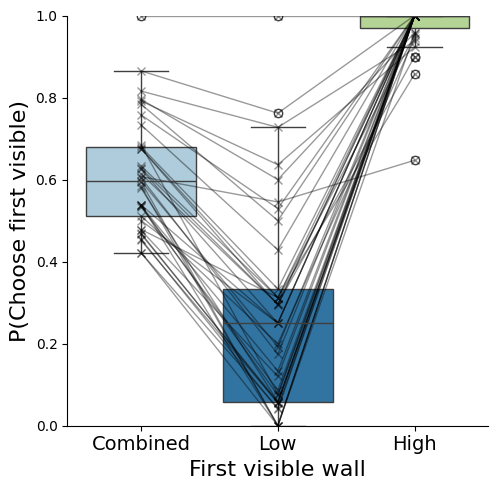

In [308]:
plot_probability_chose_wall.boxplot_probability_choose_wall(wall_choice_probabilities_solo, ['Combined', 'Low', 'High'], ylabel="P(Choose first visible)",
                                                            xlabel="First visible wall", fontsize=16)

### Combine wall vis between High and Low within solo and social, then plot this comparing Solo and Social 

In [233]:
len(denominator1_solo[-5])

2

In [327]:
probabilities3

array([0.77272727, 0.73076923, 0.83333333, 0.66101695, 0.60784314,
       0.83606557, 0.76404494, 0.76146789, 0.82608696, 0.78723404,
       0.76811594, 0.72222222, 0.81578947, 0.70666667, 0.73333333,
       0.65432099, 0.60784314, 0.71014493, 0.61971831, 0.71875   ,
       0.74285714, 0.5483871 , 0.67142857, 0.65116279, 0.7       ,
       0.63934426, 0.6557377 , 0.86538462, 0.7       , 0.725     ,
       0.69333333, 0.625     , 0.77464789, 0.47887324, 0.75471698,
       0.65789474, 0.63636364, 0.40350877])

In [328]:
probabilities3_solo

array([0.86486486, 0.51162791, 0.45454545, 0.79545455, 0.5       ,
       0.53846154, 0.62745098, 0.73333333, 0.60714286, 0.81578947,
       0.61403509, 0.53703704, 0.53846154, 0.57894737, 0.47826087,
       0.53571429, 0.63333333, 0.4516129 , 0.42105263, 1.        ,
       0.79166667, 0.46875   , 0.67567568, 0.59459459, 0.75757576,
       0.67567568, 0.58333333, 0.625     , 0.78378378, 0.47619048,
       0.46666667, 0.68      , 0.68421053,        nan, 0.42222222,
       0.60416667, 0.59615385, 0.53333333])

d:\tom\documents\swc\repos\octagon_analysis\plotting\plot_probability_chose_wall.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Condition", y="Probability", data=df, palette=custom_palette, width=.8)
d:\tom\documents\swc\repos\octagon_analysis\plotting\plot_probability_chose_wall.py:60: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(x="Condition", y="Probability", data=df, palette=custom_palette, width=.8)


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

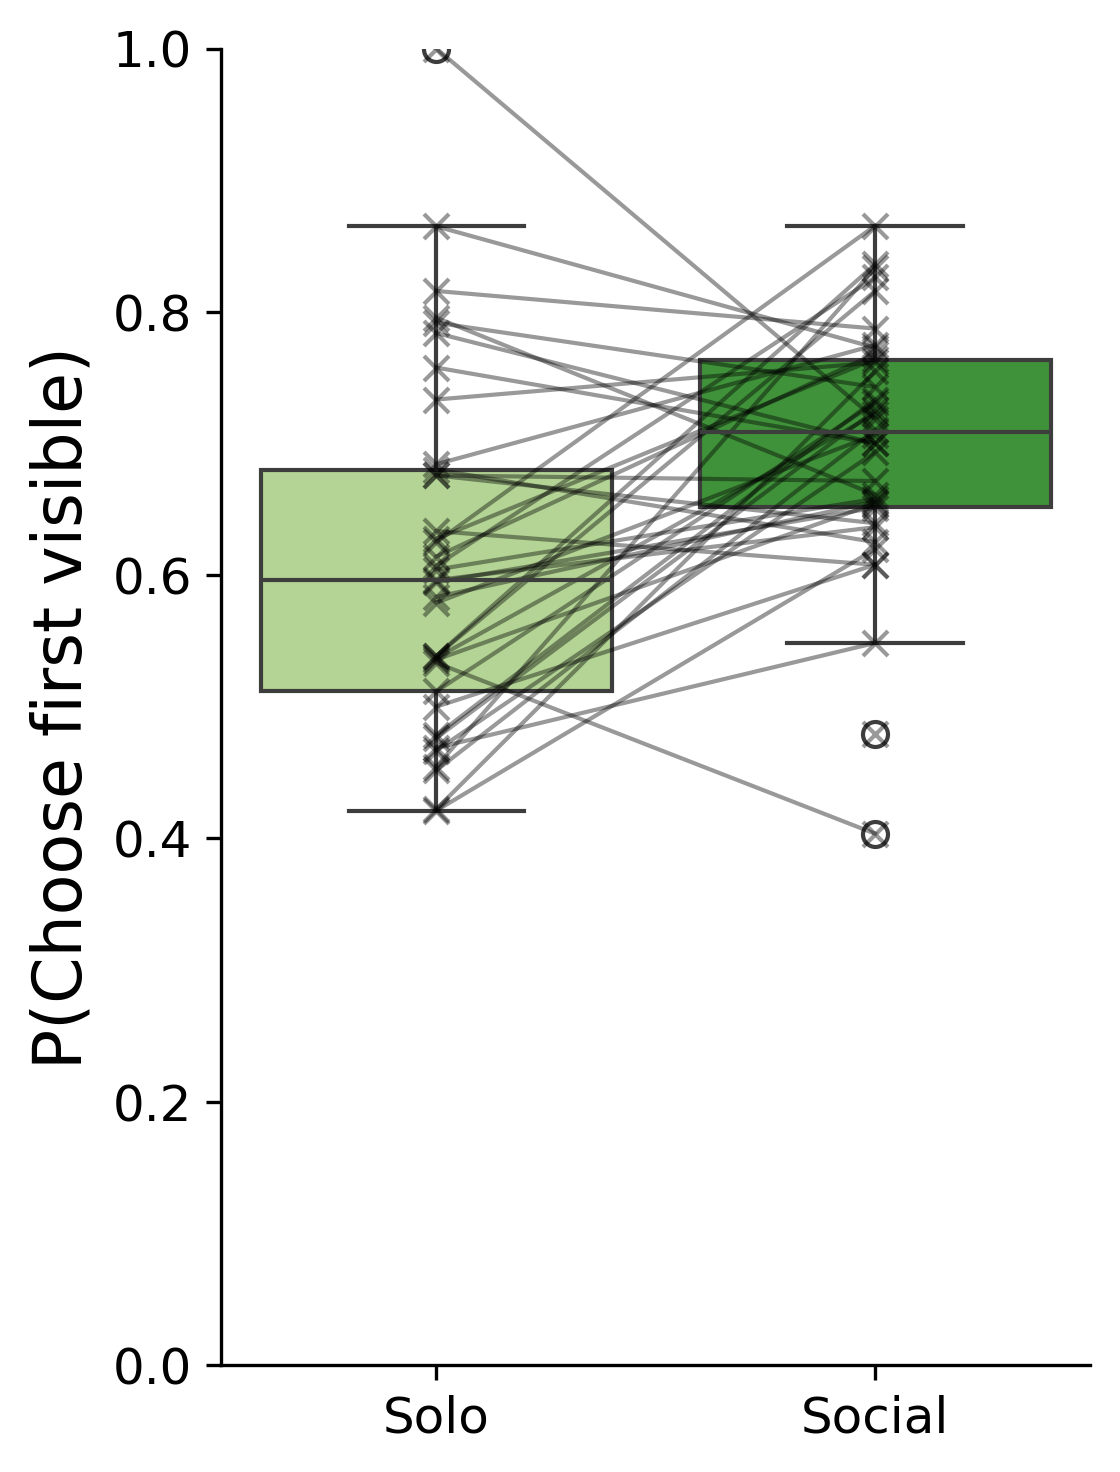

In [47]:
wall_choice_probabilities_solo_social = [probabilities3_solo, probabilities3]
ax = plot_probability_chose_wall.boxplot_probability_choose_wall(wall_choice_probabilities_solo_social, ['Solo', 'Social'], ylabel="P(Choose first visible)",
                                                            fontsize=16)
ax.set_ylim([0,1.])
plt.yticks(fontsize=12)

### Wilcoxon signed rank test

In [345]:
probabilities3_solo

array([0.86486486, 0.51162791, 0.45454545, 0.79545455, 0.5       ,
       0.53846154, 0.62745098, 0.73333333, 0.60714286, 0.81578947,
       0.61403509, 0.53703704, 0.53846154, 0.57894737, 0.47826087,
       0.53571429, 0.63333333, 0.4516129 , 0.42105263, 1.        ,
       0.79166667, 0.46875   , 0.67567568, 0.59459459, 0.75757576,
       0.67567568, 0.58333333, 0.625     , 0.78378378, 0.47619048,
       0.46666667, 0.68      , 0.68421053,        nan, 0.42222222,
       0.60416667, 0.59615385, 0.53333333])

In [346]:
wilcoxon_nan_mask = ~np.isnan(probabilities3) & ~np.isnan(probabilities3_solo)
probabilities_social_wilcoxon = probabilities3[wilcoxon_nan_mask]
probabilities_solo_wilcoxon = probabilities3_solo[wilcoxon_nan_mask]

In [347]:
# Perform Wilcoxon signed-rank test
stat, p_value = wilcoxon(probabilities_social_wilcoxon, probabilities_solo_wilcoxon)

# Print results
print(f"Wilcoxon test statistic: {stat}")
print(f"P-value: {p_value}")

Wilcoxon test statistic: 144.0
P-value: 0.0012698457721853629


### Slightly older code

#### Everything below this point can be considered outdated (compared to above)

In [62]:
# variables
inferred_choice = False
current_fov = 110

In [74]:
# P(H | H first vis), for all players
(probabilities1,
 filtered_trial_indices1,
 filtered_trial_choice_indices1) = probability_trial_outcome_given_conditions_all_sessions(trial_lists, inferred_choice,
                                                                        current_fov, trial_type=globals.HIGH_LOW,
                                                                        chosen_wall_index=0, visible_wall_index=0,
                                                                        return_trial_indices=True, debug=False)

# (have confirmed that ratios of trial indices lengths is equal to my returned probabilities)

filter_trials_retrievable_choice - player_choice, inferred status False is:
[nan  2.  5.  6. nan nan  5. nan  8. nan nan  6. nan nan nan nan  1. nan
  1. nan nan  2. nan  8. nan  5.  2.  5. nan  3. nan nan nan nan nan  2.
  7. nan nan nan  6.  4.  2.  6. nan  6.  1.  7. nan nan  6. nan  3. nan
 nan nan nan nan  3. nan  1.  4.  7. nan  8.  2.  1.  1. nan nan nan nan
 nan  7. nan nan  1. nan  1.  8. nan nan  5. nan nan  2. nan nan nan nan
 nan nan nan  1.  8.  4. nan nan nan nan nan  7.]
And the number of valid trials at this step is 43
filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0.
 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1.]
And the number of valid trials at this step is 18
filter_trials_player_chose_given_wall - player choice array:
[2. 8. 6. 5. 4. 1. 7. 3. 7. 8. 2. 1. 1. 8. 2. 8. 4. 7.]
And the number trials identified with a choice at this step is 18
given w

In [75]:
# P(L | L first vis), for all players
(probabilities2,
 filtered_trial_indices2,
 filtered_trial_choice_indices2)= probability_trial_outcome_given_conditions_all_sessions(trial_lists, inferred_choice,
                                                                        current_fov, trial_type=globals.HIGH_LOW,
                                                                        chosen_wall_index=1, visible_wall_index=1,
                                                                        return_trial_indices=True, debug=False)

filter_trials_retrievable_choice - player_choice, inferred status False is:
[nan  2.  5.  6. nan nan  5. nan  8. nan nan  6. nan nan nan nan  1. nan
  1. nan nan  2. nan  8. nan  5.  2.  5. nan  3. nan nan nan nan nan  2.
  7. nan nan nan  6.  4.  2.  6. nan  6.  1.  7. nan nan  6. nan  3. nan
 nan nan nan nan  3. nan  1.  4.  7. nan  8.  2.  1.  1. nan nan nan nan
 nan  7. nan nan  1. nan  1.  8. nan nan  5. nan nan  2. nan nan nan nan
 nan nan nan  1.  8.  4. nan nan nan nan nan  7.]
And the number of valid trials at this step is 43
filter_trials_one_wall_becomes_visible_first - given_wall_first_visible_session array:
[0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0.]
And the number of valid trials at this step is 14
filter_trials_player_chose_given_wall - player choice array:
[5. 6. 5. 2. 5. 3. 6. 6. 1. 1. 7. 1. 5. 1.]
And the number trials identified with a choice at this step is 14
given wall chosen a

In [78]:
wall_choice_probabilities = [probability3, probabilities2, probabilities1]
wall_choice_labels = ["All first vis", "Low first vis", "High first vis"]

d:\tom\documents\swc\repos\octagon_analysis\plotting\plot_probability_chose_wall.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Condition", y="Probability", data=df, palette="Paired", width=.8)


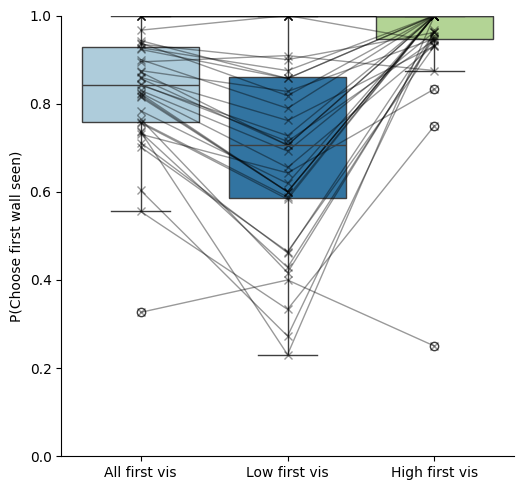

In [79]:
plot_probability_chose_wall.boxplot_probability_choose_wall(wall_choice_probabilities, wall_choice_labels, ylabel="P(Choose first wall seen)")

TODO:
- Add in the combined first vis
- Generate for different wall separations
- Generate for solo 
- Save plots 

### Combined first vis code
- Sum together all trials that came from P(H | H first vis) and P(L | L first vis) and divide by all trials with a first visible wall
  (This must be done for each player individually)

In [76]:
filtered_trial_choice_indices_total = [np.sort(a + b) for a,b in zip(filtered_trial_choice_indices1, filtered_trial_choice_indices2)]
filtered_trial_indices_total = [np.sort(a + b) for a,b in zip(filtered_trial_indices1, filtered_trial_indices2)]

probability3 = np.full(len(filtered_trial_indices_total), np.nan)
for i in range(len(filtered_trial_indices_total)):
    probability3[i] = conditioned_player_choice.calculate_probability_choose_wall(filtered_trial_indices_total[i], filtered_trial_choice_indices_total[i])

In [97]:
len(filtered_trial_indices_total[0]), len(filtered_trial_indices1[0]), len(filtered_trial_indices2[0])

(32, 18, 14)

In [77]:
probability3

array([0.84375   , 0.86      , 1.        , 0.73529412, 0.81818182,
       0.92682927, 0.9       , 0.82432432, 0.92307692, 0.9375    ,
       0.81481481, 0.89473684, 0.78378378, 0.76470588, 0.75862069,
       0.83018868, 1.        , 0.93478261, 0.70175439, 1.        ,
       1.        , 0.6031746 , 0.96666667, 0.71153846, 0.75609756,
       0.84210526, 0.73684211, 1.        , 0.94285714, 0.875     ,
       0.82222222, 0.85714286, 0.87179487, 0.55555556, 0.32653061,
       0.73076923])